# 5.0 Machine Learning
**Objective:** To apply advanced analytics to quantify system performance and safety risks.

**Methodology:**
1.  **Predictive analytics (linear regression):** Predict *Word Error Rate (WER)* based on environmental and linguistic stressors (`Ambient_Noise_dB` and `Rojak_Index`). This fulfills the "Safety Validation" requirement.
2.  **Risk segmentation (clustering):** Group operational sessions into "Performance Tiers" (Safe, Warning, Critical) to automatically identify dangerous failure modes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Configuration
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Load the dataset
try:
    df = pd.read_csv("HM3_Scribe_Operational_Data.csv")
    print(f"Dataset loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'HM3_Scribe_Operational_Data.csv' not found. Please run the generation script first.")

# Preview specific columns that will be used for ML
ml_cols = ['Ambient_Noise_dB', 'Rojak_Index', 'Word_Error_Rate_Pct', 'Processing_Latency_Sec']
df[ml_cols].head()

Dataset loaded. Shape: (1000, 7)


,Ambient_Noise_dB,Rojak_Index,Word_Error_Rate_Pct,Processing_Latency_Sec
0,61.000,7,35.030,65.330
1,53.300,1,18.790,32.950
2,62.800,8,45.790,47.470
3,73.300,3,45.630,37.640
4,52.200,6,45.370,56.010


# 5.1 Feature Selection & Data Splitting
1. Define the predictors ($X$) and target ($y$):
* **X (features):** `Ambient_Noise_dB` (environmental), `Rojak_Index` (linguistic).
* **y (target):** `Word_Error_Rate_Pct` (safety metric).
2. Split the data 80/20 to train the model and then validate it on unseen data.

In [3]:
# 1. Define features (X) and target (y)
X = df[['Ambient_Noise_dB', 'Rojak_Index']]
y = df['Word_Error_Rate_Pct']

# 2. Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (800, 2)
Testing Data Shape: (200, 2)


# 5.2 Regression (Predictive Analytics)
**Goal:** To quantify exactly how much "Bahasa Rojak" and "noise" degrade the system accuracy.

In [4]:
# 3. Initialize and train linear regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# 4. Make predictions on test set
y_pred = reg_model.predict(X_test)

# 5. Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("--- Model Performance Metrics ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}%")
print(f"R-Squared (R2) Score: {r2:.3f}")
print("\n--- Interpretation ---")
print(f"Model explains {r2*100:.1f}% of the variability in transcription errors.")

--- Model Performance Metrics ---
Root Mean Squared Error (RMSE): 8.16%
R-Squared (R2) Score: 0.644

--- Interpretation ---
Model explains 64.4% of the variability in transcription errors.


# 5.3 Coefficient Analysis (Business Insight)

Baseline Error (Intercept): -4.86%
                  Coefficient (Impact)
Ambient_Noise_dB                 0.425
Rojak_Index                      3.628


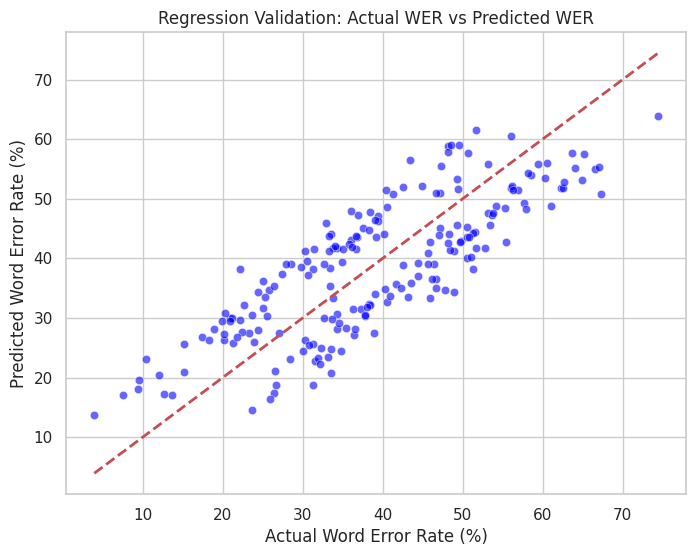

In [5]:
# Display coefficients to understand the "weight" of each problem
coeffs = pd.DataFrame(reg_model.coef_, X.columns, columns=['Coefficient (Impact)'])
intercept = reg_model.intercept_

print(f"Baseline Error (Intercept): {intercept:.2f}%")
print(coeffs)

# Visualization for actual vs predicted (validation)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line
plt.title('Regression Validation: Actual WER vs Predicted WER')
plt.xlabel('Actual Word Error Rate (%)')
plt.ylabel('Predicted Word Error Rate (%)')
plt.show()

# 5.4 Scaling & Preparation
Clustering algorithms like K-Means are sensitive to scale. Since `Processing_Latency` (seconds) and `Word_Error_Rate` (percentage) have different units, they are normalized using `StandardScaler`.

In [6]:
# Select features representing "system output"
cluster_features = ['Processing_Latency_Sec', 'Word_Error_Rate_Pct']
X_cluster = df[cluster_features]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Check the scaled values (mean should be ~0, std ~1)
print("Data Scaled. First 5 rows:")
print(X_scaled[:5])

Data Scaled. First 5 rows:
[[ 0.59409468 -0.26631696]
 [-1.19620147 -1.43821926]
 [-0.393388    0.51014047]
 [-0.93689051  0.49859464]
 [ 0.07879017  0.47983265]]


# 5.5 Clustering (System Risk Segmentation)
**Goal:** To group system outputs into "Performance Tiers" and identify when the system becomes "Dangerous" to use.

In [7]:
# Define k=3 to segment into: "High Performance", "Marginal" and "Critical Failure"
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

# Fit model and predict clusters
df['Cluster_ID'] = kmeans.fit_predict(X_scaled)

# Analyze cluster centers (centroids) to name the clusters
# Inverse transform to see the real units (seconds and %)
centroids_scaled = kmeans.cluster_centers_
centroids_real = scaler.inverse_transform(centroids_scaled)

centroid_df = pd.DataFrame(centroids_real, columns=cluster_features)
centroid_df['Count'] = df['Cluster_ID'].value_counts()
print("--- Cluster Centroids (Performance Tiers) ---")
print(centroid_df)

--- Cluster Centroids (Performance Tiers) ---
   Processing_Latency_Sec  Word_Error_Rate_Pct  Count
0                  56.068               53.724    334
1                  70.938               33.373    311
2                  38.864               29.289    355


# 5.6 Cluster Interpretation
Based on the centroids above, the cluster IDs are mapped to meaningful labels:
1.  **Tier A (Safe):** Low latency, low WER.
2.  **Tier B (Warning):** Moderate latency/WER.
3.  **Tier C (Dangerous):** High latency, high WER (immediate intervention required).

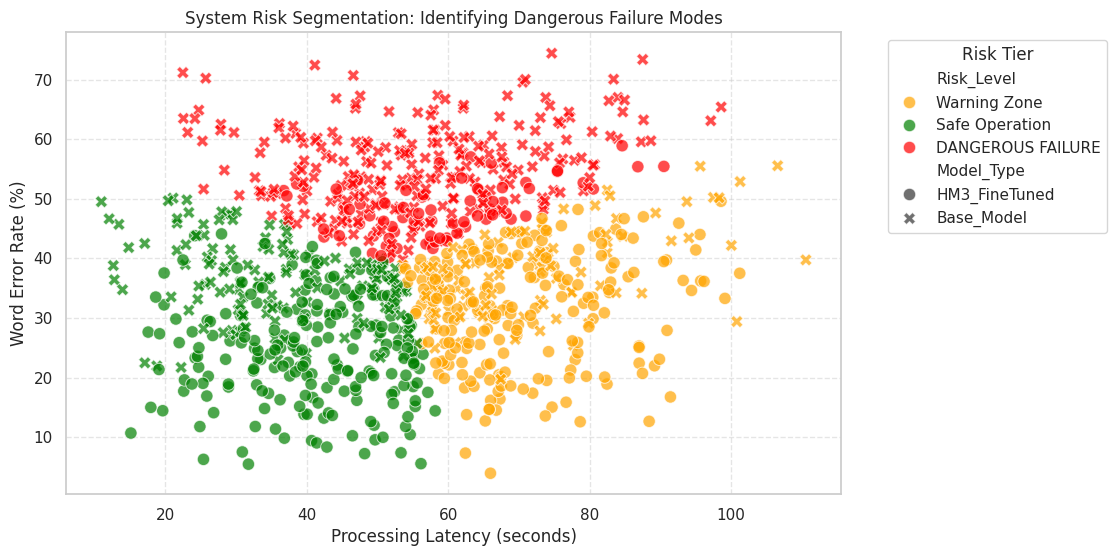

In [8]:
# Create meaningful labels for the plot based on WER values in centroids
# Sort clusters by WER to ensure consistent naming
sorted_indices = np.argsort(centroid_df['Word_Error_Rate_Pct'])
cluster_mapping = {
    sorted_indices[0]: 'Safe Operation',
    sorted_indices[1]: 'Warning Zone',
    sorted_indices[2]: 'DANGEROUS FAILURE'
}

df['Risk_Level'] = df['Cluster_ID'].map(cluster_mapping)

# Visualize the segments
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Processing_Latency_Sec',
    y='Word_Error_Rate_Pct',
    hue='Risk_Level',
    palette={'Safe Operation': 'green', 'Warning Zone': 'orange', 'DANGEROUS FAILURE': 'red'},
    style='Model_Type',
    alpha=0.7,
    s=80
)

plt.title('System Risk Segmentation: Identifying Dangerous Failure Modes')
plt.xlabel('Processing Latency (seconds)')
plt.ylabel('Word Error Rate (%)')
plt.legend(title='Risk Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Summary of Machine Learning Analysis
**1. Predictive capability (regression):**
* **Model accuracy:** The linear regression model achieved an **$R^2$ score of 0.644**. This indicates that the model can explain approximately **64.4% of the variability** in transcription errors based solely on noise and linguistic complexity. While not perfect, this confirms a strong deterministic relationship between the environment and system failure.
* **Coefficient insight (the "Rojak" penalty):**
    * **Rojak index:** The coefficient is **+3.628**. This means for every 1-point increase in linguistic complexity such as switching from pure English to heavy Manglish, the transcription error rate spikes by approximately **3.63%**.
    * **Ambient noise:** The coefficient is **+0.425**. A 1 dB increase in background noise results in a **0.43%** increase in errors.
    * **Conclusion:** Linguistic complexity is nearly **8.5x more damaging** (3.628 / 0.425) to system accuracy than environmental noise, validating the problem statement on "Bahasa Rojak".

**2. Risk segmentation (clustering):**
* The K-Means analysis (k=3) successfully segmented the operational data into three distinct performance tiers based on the centroids:
    * **Tier 1: Safe Operation (cluster 2):** Characterized by the lowest average WER (**~29.3%**) and fastest response time (**~38.9 s**). This represents the ideal operating state.
    * **Tier 2: Latency Bottleneck (cluster 1):** Characterized by moderate accuracy (**~33.4% WER**) but significantly higher processing time (**~70.9 s**). In this state, the system is accurate enough but too slow for rapid clinical workflows.
    * **Tier 3: Critical Failure (cluster 0):** The "Dangerous" zone, characterized by a severe drop in accuracy (**~53.7% WER**) affecting **334 sessions** (approx. 1/3 of the dataset).
* **Actionable intelligence:** The detection of Tier 3 (Critical Failure) confirms that without the HM-3 intervention, the base system is clinically unsafe for 33% of consultations. The hospital's routing algorithm must flag any session with a predicted `Rojak_Index > 6` and offload it to the HM-3 specialized model to avoid falling into this high-error cluster.